# Identifying Optotagged Units
In some transgenic mice, particular types of neurons express a trait whereby they will fire in response to direct laser stimulation. This is stored in the `optogenetic_stimulation` table of our NWB files. Identifying these cells is called *Optotagging*. Optotagging makes it possible to link the in vivo spike recordings of neuronal units to genetically defined cell classes. Doing this analysis with the optogenetic stimulus information is relatively similar to the analysis in [Visualizing Neuronal Unit Spikes](../visualization/visualize_unit_responses.ipynb). To do this, we take all the relevant stimulation times from the stimulus table and identify which neuronal units fire within a predetermined window of time following the stimulus times. Neurons that spike more frequently and consistently after stimulus are likely to be optotagged.

### Environment Setup
⚠️**Note: If running on a new environment, run this cell once and then restart the kernel**⚠️

In [1]:
try:
    from dandi_utils import dandi_download_open
except:
    !git clone https://github.com/AllenInstitute/openscope_databook.git
    %cd openscope_databook
    %pip install -e .

c:\Users\carter.peene\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\carter.peene\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
c:\Users\carter.peene\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
import time

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy.stats import mannwhitneyu
from scipy.stats import median_abs_deviation
from scipy.stats import kstest

%matplotlib inline

### Downloading Ecephys File
The example file we use is from the Allen Institute's **Visual Coding - Neuropixels** dataset. To specify your own file to use, set `dandiset_id` and `dandi_filepath` to be the respective dandiset id and dandi filepath of the file you're interested in. When accessing an embargoed dataset, set `dandi_api_key` to be your DANDI API key. If you want to stream a file instead of downloading it, change `dandi_download_open` to `dandi_stream_open`. Checkout [Streaming an NWB File with fsspec](../basics/stream_nwb.ipynb) for more information on this.

In [3]:
dandiset_id = "000021"
dandi_filepath = "sub-707296975/sub-707296975_ses-721123822.nwb"
download_loc = "."
dandi_api_key = None

In [4]:
# This can sometimes take a while depending on the size of the file
io = dandi_download_open(dandiset_id, dandi_filepath, download_loc, dandi_api_key=dandi_api_key)
nwb = io.read()

A newer version (0.56.0) of dandi/dandi-cli is available. You are using 0.55.1


File already exists
Opening file


c:\Users\carter.peene\AppData\Local\Programs\Python\Python39\lib\site-packages\hdmf\spec\namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.5.1 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
c:\Users\carter.peene\AppData\Local\Programs\Python\Python39\lib\site-packages\hdmf\spec\namespace.py:531: UserWarning: Ignoring cached namespace 'core' version 2.2.2 because version 2.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


### Extracting Optogenetic Stimulus Data and Units Data
The two components needed for this analysis are the `optogenetic_stimulation` table and the `Units` table. The optogenetic stimulus table contains the intervals where lasers are fired at the brain. The primary property we will use from this is `start_time` which contains the times that stimulus is presented. From the `Units` table, we will extract the `spike_times` which will be aligned relative to a predefined window of time around each stimulus time to determine if it occurred in response to the stimulus. These tables are retrieved and printed below.

In [5]:
stim_table = nwb.processing["optotagging"]["optogenetic_stimulation"]
timestamps = nwb.processing["optotagging"]["optotagging"].timestamps
data = nwb.processing["optotagging"]["optotagging"].data

In [6]:
stim_table[:10]

,start_time,condition,level,stop_time,stimulus_name,duration,tags,timeseries
id,,,,,,,,
0,9220.52165,2.5 ms pulses at 10 Hz,4.0,9221.52165,fast_pulses,1.00,[optical_stimulation],"[(0, 1, optotagging pynwb.base.TimeSeries at 0..."
1,9222.33204,a single square pulse,4.0,9222.34204,pulse,0.01,[optical_stimulation],"[(1, 1, optotagging pynwb.base.TimeSeries at 0..."
2,9224.46178,half-period of a cosine wave,4.0,9225.46178,raised_cosine,1.00,[optical_stimulation],"[(2, 1, optotagging pynwb.base.TimeSeries at 0..."
3,9226.57153,half-period of a cosine wave,1.0,9227.57153,raised_cosine,1.00,[optical_stimulation],"[(3, 1, optotagging pynwb.base.TimeSeries at 0..."
4,9228.36932,2.5 ms pulses at 10 Hz,2.5,9229.36932,fast_pulses,1.00,[optical_stimulation],"[(4, 1, optotagging pynwb.base.TimeSeries at 0..."
5,9230.26472,half-period of a cosine wave,4.0,9231.26472,raised_cosine,1.00,[optical_stimulation],"[(5, 1, optotagging pynwb.base.TimeSeries at 0..."
6,9232.08225,a single square pulse,4.0,9232.09225,pulse,0.01,[optical_stimulation],"[(6, 1, optotagging pynwb.base.TimeSeries at 0..."
7,9233.81129,half-period of a cosine wave,4.0,9234.81129,raised_cosine,1.00,[optical_stimulation],"[(7, 1, optotagging pynwb.base.TimeSeries at 0..."
8,9235.64145,2.5 ms pulses at 10 Hz,2.5,9236.64145,fast_pulses,1.00,[optical_stimulation],"[(8, 1, optotagging pynwb.base.TimeSeries at 0..."


In [7]:
set(stim_table.duration)

{0.0049999999991996455, 0.01000000000021828, 1.0}

In [8]:
units = nwb.units
units[:10]

,amplitude_cutoff,firing_rate,presence_ratio,snr,velocity_below,isolation_distance,silhouette_score,velocity_above,nn_miss_rate,PT_ratio,...,cluster_id,waveform_halfwidth,waveform_duration,recovery_slope,amplitude,spread,isi_violations,spike_times,spike_amplitudes,waveform_mean
id,,,,,,,,,,,,,,,,,,,,,
950907203,0.376577,2.533384,0.99,2.830406,NaN,6.340840e+01,NaN,0.073582,0.000781,0.545221,...,0,0.151089,0.274707,-0.044249,45.540300,70.0,0.06548,"[1.8463237565528026, 1.9619905358580827, 2.311...","[8.327628219252525e-05, 8.367903428567035e-05,...","[[0.0, 1.4724449999999971, -0.393510000000004,..."
950907522,0.022585,0.055246,0.65,0.622514,NaN,1.211930e+01,NaN,-0.171692,0.001937,0.354055,...,153,0.219765,0.480737,-0.007213,49.501937,70.0,0.00000,"[75.19259518261279, 186.3849701306289, 191.589...","[7.996977585316541e-05, 6.97690878117426e-05, ...","[[0.0, -1.6420295202952053, 2.3475553505535047..."
950907205,0.012123,14.739577,0.99,2.838052,NaN,1.291725e+02,0.193312,-0.892797,0.004831,1.054721,...,1,0.109883,0.151089,-0.244173,101.262915,40.0,0.00510,"[0.6211892301590656, 0.9079561760850958, 1.081...","[5.270051606545425e-05, 5.0142859160195626e-05...","[[0.0, -0.9787049999999999, -4.640805000000003..."
950907520,0.007576,1.098404,0.99,2.423808,NaN,6.282138e+01,0.137635,0.824121,0.001901,0.456900,...,152,0.206030,0.329648,-0.053915,85.989735,50.0,0.00000,"[2.1005573374638606, 3.85505904603257, 4.01682...","[7.694648306411865e-05, 7.492886255594172e-05,...","[[0.0, -1.4923350000000075, -1.402439999999998..."
950907518,0.075400,0.062280,0.87,2.263385,NaN,3.500339e+01,0.173800,0.206030,0.000000,0.434353,...,151,0.178559,0.343384,-0.053040,84.470426,50.0,0.00000,"[1.9085904838560483, 5.879527684167119, 31.678...","[7.178091557968419e-05, 6.456652055153236e-05,...","[[0.0, -3.4937234042553165, 3.7997872340425505..."
950907524,0.002313,1.448536,0.99,4.285082,0.686767,5.045019e+01,0.143138,0.068677,0.001834,0.558508,...,154,0.164824,0.357119,-0.123923,136.843200,60.0,0.00000,"[2.348824245897788, 2.5458577711062924, 2.6720...","[0.00011948493821011336, 0.0001511098249575643...","[[0.0, 2.527005000000001, 1.158495000000003, 0..."
950907209,0.084063,0.040263,0.96,3.343694,0.000000,1.992695e+01,NaN,0.156975,0.000467,0.637890,...,3,0.178559,0.343384,-0.115789,114.131278,70.0,0.00000,"[10.606598954149941, 21.535109596551273, 52.97...","[9.775257470604628e-05, 9.453428297313494e-05,...","[[0.0, 3.588493670886069, 2.7976329113924, 1.2..."
950907207,0.500000,0.007849,0.04,1.429174,-1.373534,1.143549e+02,NaN,1.178950,0.000067,1.086981,...,2,0.137353,0.467002,-0.087455,58.044156,100.0,0.00000,"[9220.822768046102, 9221.122635004784, 9221.42...","[6.54109900575074e-05, 7.75283889854388e-05, 6...","[[0.0, 0.48370129870129897, 2.144999999999998,..."
950907528,0.500000,0.003160,0.29,2.618464,0.343384,1.376060e+13,NaN,0.629537,0.000000,0.551650,...,156,0.164824,0.315913,-0.106002,82.516452,110.0,0.00000,"[380.3052589740686, 1307.7695954906458, 1546.2...","[7.262832980570496e-05, 8.690587004932377e-05,...","[[0.0, -13.234838709677422, -15.53080645161290..."


### Selecting Units and Stimuli
Here subsets of the data can be selected for analysis. The important properties of the stimulus table shown above are, `condition` (type of laser pulse presented), the voltage `level`, and the `duration`. Below, you can define `stim_select` to select individual rows of the table based on these properties.

The same can be done for the units table by defining the function `unit_select`. For information on the properties of the `Units` table, see [Visualizing Unit Quality Metrics](../visualization/visualize_unit_metrics.ipynb)

In [9]:
stim_select = lambda row: float(row.duration) > 0.009 and float(row.duration) < 0.012
# stim_select = lambda row: True
stim_times = [float(row.start_time) for row in stim_table if stim_select(row)]

# unit_select = lambda row: float(row.firing_rate) > 4
# unit_select = lambda row: True
# units_spike_times = [row.spike_times.iloc[0] for row in units if unit_select(row)]
units_spike_times = units["spike_times"]

### Plotting Unit Responses
Here, the spike times of the selected units are used along with the selected stimulus times. In this example, the spike times are aligned to a window from -0.01 to 0.025 seconds around the stimulus start times and counted into bins. The result is a 2D array of spike counts over the time window for each unit. The 3D `spike_matrix` and 2D `spike_counts` arrays will be used for further analysis later on.  Also below is the function `show_counts`. This will be used with `spike_counts` and variations of this array to display various plots. You may change the variables in the next cell to suit your analysis

In [10]:
# period to exclude from analysis before and after the stimulus event 
censor_period = 0.001

# ending time of stimulus period
stim_duration = 0.01

# bin size for counting spikes
time_resolution = 0.0005

# start and end times (relative to the stimulus at 0 seconds) that we want to examine and align spikes to
# the baseline interval will be window_time_start to 0-censor_period
window_time_start = -0.01
window_time_end = 0.025

In [11]:
# time bins used
n_bins = int((window_end_time - window_start_time) / time_resolution)
bin_edges = np.linspace(window_start_time, window_end_time, n_bins, endpoint=True)

# useful throughout analysis
n_units = len(units_spike_times)
n_trials = len(stim_times)

# calculate baseline and stimulus interval indices for use later
stim_start_time = censor_period
stim_end_time = stim_start_time + stim_duration

stim_start_idx = int((stim_start_time - (bin_edges[0])) / time_resolution)
stim_end_idx = int((stim_end_time - (bin_edges[0])) / time_resolution)
bl_start_idx = 0
bl_end_idx = int((0-censor_period-bin_edges[0]) / time_resolution)

In [12]:
# 3D spike matrix to be populated with spike counts
spike_matrix = np.zeros((n_units, len(bin_edges), n_trials))

# populate 3D spike matrix for each unit for each stimulus trial by counting spikes into bins
for unit_idx in range(n_units):
    spike_times = units_spike_times[unit_idx]

    for stim_idx, stim_time in enumerate(stim_times):
        # get spike times that fall within the bin's time range relative to the stim time        
        first_bin_time = stim_time + bin_edges[0]
        last_bin_time = stim_time + bin_edges[-1]
        first_spike_in_range, last_spike_in_range = np.searchsorted(spike_times, [first_bin_time, last_bin_time])
        spike_times_in_range = spike_times[first_spike_in_range:last_spike_in_range]

        # convert spike times into relative time bin indices
        bin_indices = ((spike_times_in_range - (first_bin_time)) / time_resolution).astype(int)
        
        # mark that there is a spike at these bin times for this unit on this stim trial
        for bin_idx in bin_indices:
            spike_matrix[unit_idx, bin_idx, stim_idx] += 1

# aggregate all stim trials to get total spikes by unit over time
spike_counts = np.sum(spike_matrix, axis=2)

In [13]:
### method to show plot of spike counts of units over time

def show_counts(counts_array, stim_bounds=[], title="", c_label="", vmin=None, vmax=None):
    fig, ax = plt.subplots(figsize=(6,12)) # change fig size for different plot dimensions
    img = ax.imshow(counts_array, 
                    extent=[np.min(bin_edges), np.max(bin_edges), 0, len(counts_array)], 
                    aspect="auto",
                    vmin=vmin,
                    vmax=vmax) # change vmax to get a better depiction of your data

    for bound in stim_bounds:
        ax.plot([bound, bound],[0, len(counts_array)], ':', color='white', linewidth=1.0)

    ax.set_xlabel("Time relative to stimulus onset (s)")
    ax.set_ylabel("Unit #")

    ax.set_title(title)

    cbar = fig.colorbar(img, shrink=0.5)
    cbar.set_label(c_label)

#### Unit spike counts

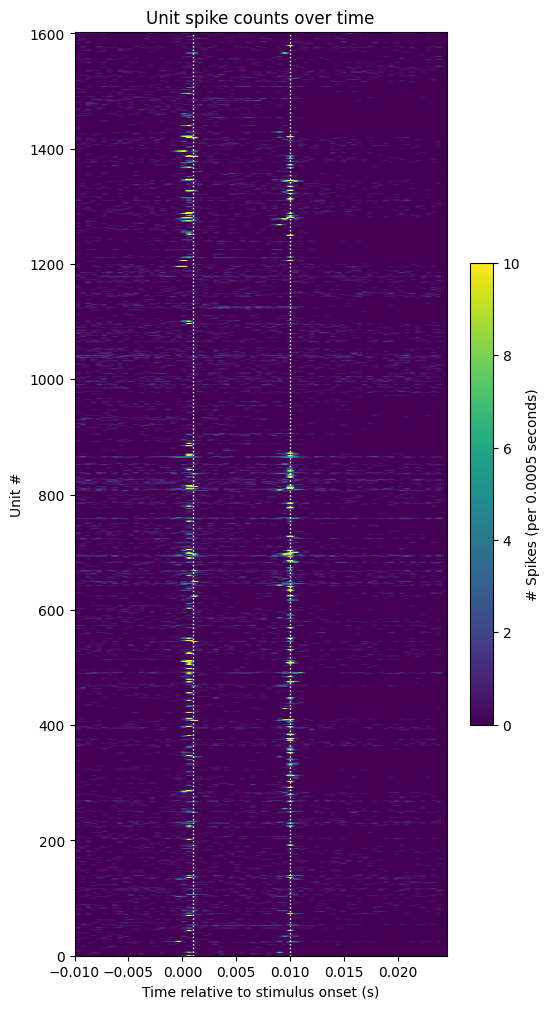

In [14]:
show_counts(spike_counts,
            stim_bounds=[censor_period, stim_duration],
            title="Unit spike counts over time",
            c_label=f"# Spikes (per {time_resolution} seconds)",
            vmin=0,
            vmax=10)

### Identifying Optotagged Units
Now that the `spike_counts` array has been made, several other plots can be generated as well. Below, the mean and the standard deviation are taken for each unit of the baseline spiking behavior before any stimulus is presented. These are used to calculate the *[Z-score](https://en.wikipedia.org/wiki/Standard_score)* over time for each unit. This normalizes the data to get a better view of the units that clearly respond to stimulus. The same plot is also sorted based on the maximum Z-score for each unit and displayed. Finally, the spike counts plot is shown again but only of units that have a maximum Z-score above a certain arbitrary value (6 here). These units are the most responsive to the stimulus. In other words, units which are likely to be optotagged. 

Note that there are also some units that seem to fire at the very beginning and/or very end of the light pulse. These spikes are almost certainly artifactual, as it takes at least 1 ms to generate a true light-evoked action potential.

#### Unit Z-scores

In [15]:
bl_mean_counts = np.mean(spike_counts[:,bl_start_idx:bl_end_idx],axis=1)
bl_mean_counts = np.expand_dims(bl_mean_counts, axis=1)

bl_std_counts = np.std(spike_counts[:,bl_start_idx:bl_end_idx],axis=1)
bl_std_counts[bl_std_counts == 0] = 1
bl_std_counts = np.expand_dims(bl_std_counts, axis=1)

normalized_spike_counts = (spike_counts - bl_mean_counts) / bl_std_counts

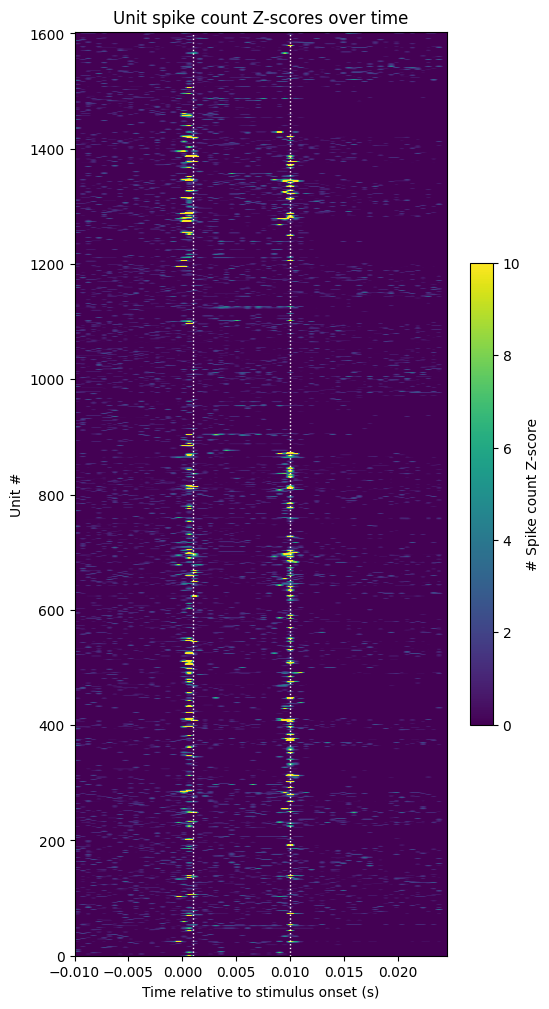

In [16]:
show_counts(normalized_spike_counts,
            stim_bounds=[censor_period, stim_duration],
            title="Unit spike count Z-scores over time",
            c_label=f"# Spike count Z-score",
            vmin=0,
            vmax=10)

#### Sorted Unit Z-scores

In [17]:
sorted_indices = np.argsort(np.max(normalized_spike_counts, axis=1))
sorted_indices.shape
sorted_normalized_spike_counts = np.take(normalized_spike_counts, sorted_indices, axis=0)

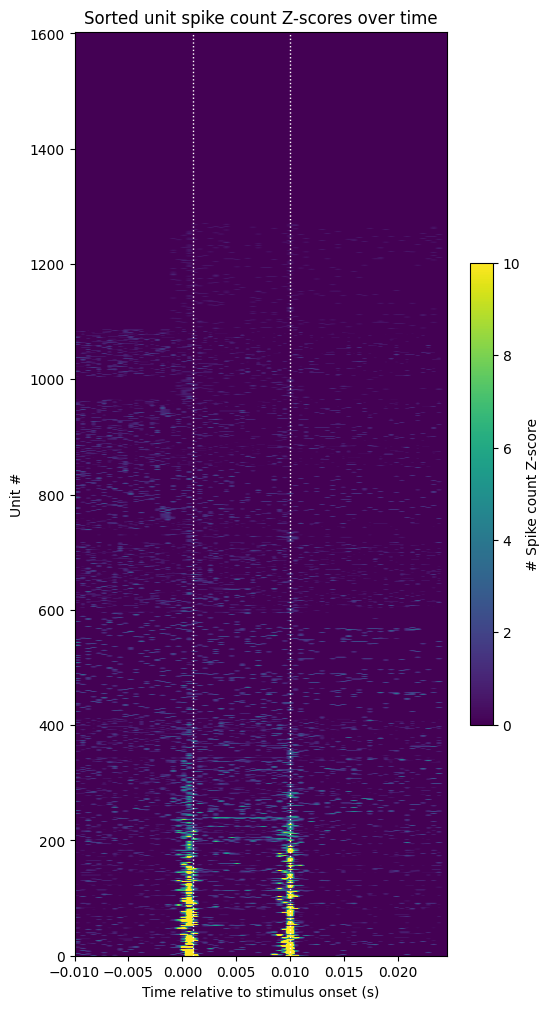

In [18]:
show_counts(sorted_normalized_spike_counts,
            stim_bounds=[censor_period, stim_duration],
            title="Sorted unit spike count Z-scores over time",
            c_label=f"# Spike count Z-score",
            vmin=0,
            vmax=10)

#### Responsive Unit Spike Counts

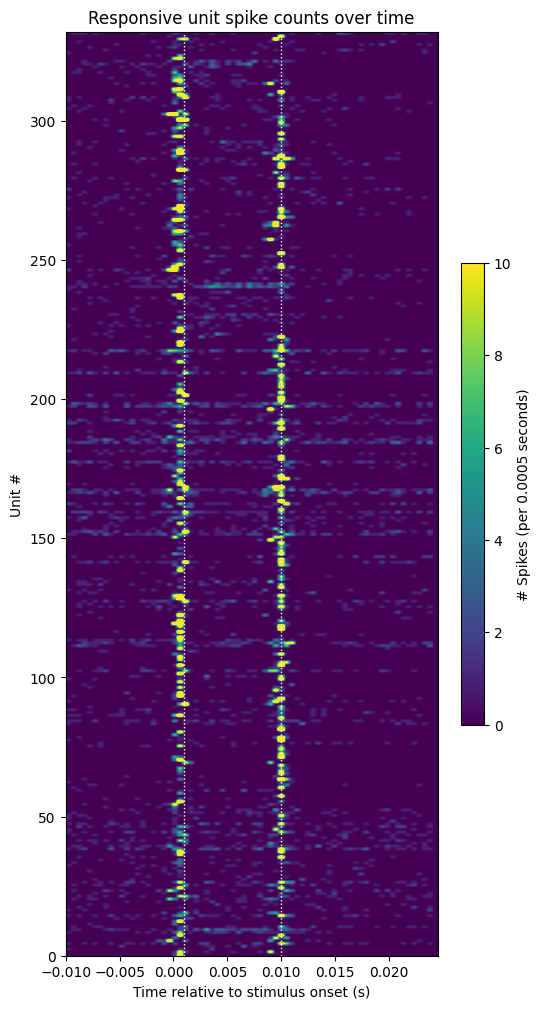

In [19]:
# filter down to units with a max response 6 stds above their baseline
filtered_spike_counts = spike_counts[np.max(normalized_spike_counts, axis=1) > 6]
show_counts(filtered_spike_counts,
            stim_bounds=[censor_period, stim_duration],
            title="Responsive unit spike counts over time",
            c_label=f"# Spikes (per {time_resolution} seconds)",
            vmin=0,
            vmax=10)

### Calculating Unit Optotagging Metrics
Here, certain metrics are calculated for each unit based on their spiking behaviors in response to stimulus. There is no single standard for what metrics to use for determining optotagged units, but the ones below may prove useful. You can adapt this code to calculate additional metrics for the units as well. Each function below calculates a metric (or two) for a given unit. As input, they use the `spike_counts`, and `spike_matrix` arrays which were already generated earlier, as well as the `stim_times` and `units_spike_times` which were produced from the NWB file. Finally, these metrics are displayed for each unit table below.

In [20]:
start_times = np.array(stim_times) + censor_period

# utility function used by first_spike_latencies_and_jitters and ks_salt
# returns an array of length 'start_times' with the first spike time after each `start_time` (and the censor period)
def get_first_spikes_after_onset(spike_times, start_times):
    response_start_times = start_times[start_times < spike_times.max()]

    first_spike_idxs = np.searchsorted(spike_times, response_start_times)
    first_spike_times = spike_times[first_spike_idxs] - response_start_times
    first_spike_times += censor_period
    
    return first_spike_times

def first_spike_latencies_and_jitters(unit_idx):
    spike_times = np.array(units_spike_times[unit_idx])
    first_spike_times = get_first_spikes_after_onset(spike_times, start_times)
    
    first_spike_jitter = median_abs_deviation(first_spike_times)
    first_spike_latency = np.median(first_spike_times)
    
    return first_spike_jitter, first_spike_latency

def ks_salt(unit_idx):
    spike_times = units_spike_times[unit_idx]
    first_spikes = get_first_spikes_after_onset(spike_times, start_times)
 
    # get first spikes at some time sufficiently prior the stimulus times so as to be a baseline period
    # but not too far back, for risk of sampling time during a previous stimulus event
    baseline_spikes = get_first_spikes_after_onset(spike_times, start_times-0.01)
    
    try:
        return kstest(first_spikes, baseline_spikes)[1]
    except:
        return np.nan

In [21]:
def fraction_time_responsive(unit_idx, bl_trial_counts):
    bl_mean_count = np.mean(bl_trial_counts)
    
    bins_pvals = []
    bins_above_baseline = []
    
    for bin_idx in range(stim_start_idx, stim_end_idx):
        time_bin = spike_matrix[unit_idx, bin_idx]
        bins_pvals.append(mannwhitneyu(bl_trial_counts, time_bin)[1])
        bins_above_baseline.append(np.mean(time_bin) > bl_mean_count)

    num_sig_bins = np.sum( (np.array(bins_pvals)<0.01) & np.array(bins_above_baseline) )
    fraction_sig_bins = num_sig_bins / (stim_end_idx-stim_start_idx)
    return fraction_sig_bins

def fraction_trials_responsive(unit_idx, bl_trial_counts):
    bl_mean_count = np.mean(bl_trial_counts)
    
    trials_pvals = []
    trials_above_baseline = []
    
    for trial_idx in range(n_trials):
        trial = spike_matrix[unit_idx, stim_start_idx:stim_end_idx, trial_idx]
        trials_pvals.append(mannwhitneyu(bl_trial_counts, trial)[1])
        trials_above_baseline.append(np.mean(trial) > bl_mean_count)

    num_sig_trials = np.sum( (np.array(trials_pvals)<0.01) & np.array(trials_above_baseline) )
    fraction_sig_trials = num_sig_trials / n_trials
    return fraction_sig_trials

In [22]:
avg_spikes = spike_counts[:,stim_start_idx:stim_end_idx] / n_trials
mean_response_spike_rates = np.mean(avg_spikes, axis=1)

# these will be populated for each unit
first_spike_jitters = np.zeros((n_units))
first_spike_latencies = np.zeros((n_units))
fracs_time_responsive = np.zeros((n_units))
fracs_trials_responsive = np.zeros((n_units))
salts = np.zeros((n_units))

# populate each optotagging metric array for each unit
for unit_idx in range(n_units):
    first_spike_jitter, first_spike_latency = first_spike_latencies_and_jitters(unit_idx)
    first_spike_jitters[unit_idx] = first_spike_jitter
    first_spike_latencies[unit_idx] = first_spike_latency
    
    # use the mean baseline spike counts for each trial to determine when the unit is 'responsive'
    bl_trial_counts = np.mean(spike_matrix[unit_idx,bl_start_idx:bl_end_idx], axis=0)
    fracs_time_responsive[unit_idx] = fraction_time_responsive(unit_idx, bl_trial_counts)
    fracs_trials_responsive[unit_idx] = fraction_trials_responsive(unit_idx, bl_trial_counts)

    salts[unit_idx] = ks_salt(unit_idx)

C:\Users\carter.peene\AppData\Roaming\Python\Python39\site-packages\scipy\stats\_stats_py.py:8057: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  return ks_2samp(xvals, yvals, alternative=alternative, method=method)
c:\Users\carter.peene\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\carter.peene\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [23]:
df = pd.DataFrame({"mean response spike rate": mean_response_spike_rates,
                   "first spike jitter": first_spike_jitters,
                   "first spike latency": first_spike_latencies,
                   "fraction time responsive": fracs_time_responsive,
                   "fraction trials responsive": fracs_trials_responsive,
                   "ks salt value": salts
                  })
df

,mean response spike rate,first spike jitter,first spike latency,fraction time responsive,fraction trials responsive,ks salt value
0,0.002339,0.130425,0.189092,0.0,0.0,0.947879
1,0.001170,3.172385,3.636217,0.0,0.0,1.000000
2,0.003509,0.020110,0.040316,0.0,0.0,0.947879
3,0.001170,1.410416,1.535328,0.0,0.0,1.000000
4,0.000000,21.937948,26.698553,0.0,0.0,1.000000
...,...,...,...,...,...,...
1598,0.000000,4.755991,7.256958,0.0,0.0,1.000000
1599,0.011696,0.164228,0.174146,0.0,0.0,0.947879
1600,0.001170,0.106204,0.205461,0.0,0.0,0.653387
1601,0.000000,1.026929,1.225496,0.0,0.0,0.999981
